## DPC Policy train


## Prepare packages

In [107]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import pickle
from pickle import dump

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from scipy.optimize import minimize, Bounds
from scipy.stats import qmc
from torchmin import minimize as pytorch_minimize

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import os
print(os.listdir())

import importlib
import A1_x1tracking_policy
importlib.reload(A1_x1tracking_policy)

from A1_x1tracking_policy import DPC_x1_loss, DPC_Policy_x1
from TiDE import TideModule, quantile_loss, TiDE_forward

if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")
    

['mpc_training_data_processed.pickle', 'A2_dropout.py', 'A1_x1tracking_policy.py', 'E2_Execute.ipynb', 'nominal_params_w10_mid_noise_stable_final.pkl', 'test.ipynb', 'nominal_params_w10_mid_noise_stable_final.pth', '__pycache__', 'TiDE.py', 'E1_Train.ipynb', 'mpc_training_data.pickle', 'test.py']
cuda is available


## System identification (not used)

In [108]:
init_zero = 1000
def f_ss(x0,u):
    A = np.array([[0.3,0.1], [0.1, 0.2]])
    B = np.array([[0.5],[1.0]])
    mu = np.array([[0],[0]])*0
    w = np.array([[0.05],[0.1]])
    x = A@x0+B*u + np.random.normal(mu,w,size=(2,1))
    return x

def f_ss_multistep(x0,u):
    step = len(u)
    output = np.zeros([2,step])
    for i in range(step):
        x_next = f_ss(x0,u[i])
        x0 = np.copy(x_next)
        output[:,i] = x_next.reshape(-1)
    return output

## Data generation

In [109]:
import numpy as np
import pickle

# parameters
w = 5
p = 10
total_steps = int(1e5)
u_scale = 5
x1_scale = 5
x2_scale = 7

def generate_u_seq(size):
    return np.random.uniform(low=-u_scale, high=u_scale, size=size)

def generate_x1_seq(size):
    return np.random.uniform(low=-x1_scale, high=x1_scale, size=size)

def generate_x2_seq(size):
    return np.random.uniform(low=-x2_scale, high=x2_scale, size=size)

u_past = generate_u_seq(size=total_steps * w)
x1_past = generate_x1_seq(size=total_steps * w)
x1_future = generate_x1_seq(size=total_steps * p)
x2_past = generate_x2_seq(size=total_steps * w)
x2_future = generate_x2_seq(size=total_steps * p)

data = {
    'u_past': u_past,
    'x1_past': x1_past,
    'x2_past': x2_past,
    'x1_future': x1_future,
    'x2_future': x2_future
}

with open('mpc_training_data.pickle', 'wb') as f:
    pickle.dump(data, f)

# check shapes
print("Data generated:")
for key, value in data.items():
    print(f"{key}: {value.shape}")


Data generated:
u_past: (500000,)
x1_past: (500000,)
x2_past: (500000,)
x1_future: (1000000,)
x2_future: (1000000,)


## Normalize & Split data

In [110]:
# normalize
def normalize_seq(seq, scale):
    return seq / scale

# non-overlapping split
def split_nonoverlapping(seq, chunk_size):
    n_chunks = len(seq) // chunk_size
    seq = seq[:n_chunks * chunk_size]
    return seq.reshape(n_chunks, chunk_size)

# load
with open('mpc_training_data.pickle', 'rb') as f:
    data = pickle.load(f)
    
# normalize
u_seq = normalize_seq(data['u_past'], u_scale)
x1_seq = normalize_seq(data['x1_past'], x1_scale)
x2_seq = normalize_seq(data['x2_past'], x2_scale)
x1_future_seq = normalize_seq(data['x1_future'], x1_scale)
x2_future_seq = normalize_seq(data['x2_future'], x2_scale)

# split into non-overlapping windows
x1_past = split_nonoverlapping(x1_seq, w)
x2_past = split_nonoverlapping(x2_seq, w)
u_past = split_nonoverlapping(u_seq, w)
x1_future = split_nonoverlapping(x1_future_seq, p)
x2_future = split_nonoverlapping(x2_future_seq, p)

# stack
x_past = np.stack([x1_past, x2_past], axis=-1)       # [N1, w, 2]
x_future = np.stack([x1_future, x2_future], axis=-1) # [N2, p, 2]

# print
print("x_past:", x_past.shape)
print("x_future:", x_future.shape)
print("u_past:", u_past.shape)

# save
processed = {
    'x_past': x_past,
    'x_future': x_future,
    'u_past': u_past
}

with open('mpc_training_data_processed.pickle', 'wb') as f:
    pickle.dump(processed, f)

x_past: (100000, 5, 2)
x_future: (100000, 10, 2)
u_past: (100000, 5)


## NN Policy Model (build)

In [111]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader

def train_policy_tide(n_layers, hidden_dim, setting_name, device, num_epoch=100):
    # Load processed data
    with open('mpc_training_data_processed.pickle', 'rb') as f:
        data = pickle.load(f)

    # Input tensors
    x1_past = torch.tensor(data['x_past'][:, :, 0], dtype=torch.float32)
    x2_past = torch.tensor(data['x_past'][:, :, 1], dtype=torch.float32)
    x1_future = torch.tensor(data['x_future'][:, :, 0], dtype=torch.float32)
    x2_future = torch.tensor(data['x_future'][:, :, 1], dtype=torch.float32)
    u_past = torch.tensor(data['u_past'], dtype=torch.float32).unsqueeze(-1)  # (N, w, 1)

    # Train/val split
    N = x1_past.shape[0]
    split = int(0.8 * N)

    train_dataset = TensorDataset(
        x1_past[:split], x2_past[:split], u_past[:split], x1_future[:split], x2_future[:split]
    )
    val_dataset = TensorDataset(
        x1_past[split:], x2_past[split:], u_past[split:], x1_future[split:], x2_future[split:]
    )

    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512)

    # Model
    model = DPC_Policy_x1(
        input_dim=4,
        output_dim=1,
        output_chunk_length=x1_future.shape[1],
        window=w,
        hidden_dim=hidden_dim,
        n_layers=n_layers
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    best_model = None
    best_val_loss = float('inf')
    counter = 0
    patience = 30

    train_losses = []
    val_losses = []

    with tqdm(total=num_epoch, desc=setting_name) as pbar:
        for epoch in range(num_epoch):
            model.train()
            for x1p, x2p, up, x1f, _ in train_loader:
                x1p, x2p, up, x1f = x1p.to(device), x2p.to(device), up.to(device), x1f.to(device)

                x_in = (x1p, x2p, up, x1f)
                optimizer.zero_grad()
                u_pred = model(x_in)  # shape: (B, p, 1, 3)
                u_median = u_pred.median(dim=-1).values  # (B, p, 1)

                # TiDE input
                tide_input = (torch.cat([x1p, x2p], dim=-1), u_median, None)  # (x_past, u_future, None)
                tide_output = nominal_TiDE(tide_input)  # should return (B, p, 2)

                target = torch.cat([x1f, _], dim=-1).to(device)  # (B, p, 2)
                loss = F.mse_loss(tide_output, target)

                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                val_total_loss = 0.0
                for x1p, x2p, up, x1f, x2f in val_loader:
                    x1p, x2p, up, x1f, x2f = x1p.to(device), x2p.to(device), up.to(device), x1f.to(device), x2f.to(device)
                    x_in = (x1p, x2p, up, x1f)
                    u_pred = model(x_in).median(dim=-1).values.squeeze(-1)

                    tide_input = (torch.cat([x1p, x2p], dim=-1), u_pred, None)
                    tide_output = nominal_TiDE(tide_input)
                    target = torch.cat([x1f, x2f], dim=-1)
                    val_loss = F.mse_loss(tide_output, target)

                    val_total_loss += val_loss.item()

                val_avg = val_total_loss / len(val_loader)

            train_losses.append(loss.item())
            val_losses.append(val_avg)

            if val_avg < best_val_loss:
                best_val_loss = val_avg
                best_model = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

            scheduler.step()
            pbar.set_description(f"{setting_name} | Train: {loss.item():.4f} | Val: {val_avg:.4f}")
            pbar.update(1)

    torch.save(best_model, f"policy_model_{setting_name}.pth")
    return {
        "train_loss": train_losses,
        "val_loss": val_losses
    }


In [112]:
with open('nominal_params_w10_mid_noise_stable_final.pkl', 'rb') as file: 
    nominal_params = pickle.load(file)
nominal_TiDE = nominal_params['model'].to("cpu")
nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_mid_noise_stable_final.pth'))
nominal_TiDE.eval()

window = 10

nominal_TiDE = nominal_TiDE.to(device)

In [113]:
import pickle
import torch

# model configurations
config_list = [(5, 512)]  # (n_layers, hidden_dim)
num_epoch = 100
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for n_layers, hidden_dim in config_list:
    setting_name = f"{n_layers}L_{hidden_dim}H"
    result = train_policy_tide(
        n_layers=n_layers,
        hidden_dim=hidden_dim,
        setting_name=setting_name,
        device=device,
        num_epoch=num_epoch
    )
    results[setting_name] = result

# save
with open("policy_losses.pkl", "wb") as f:
    pickle.dump(results, f)


5L_512H:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

## 08. Loss history

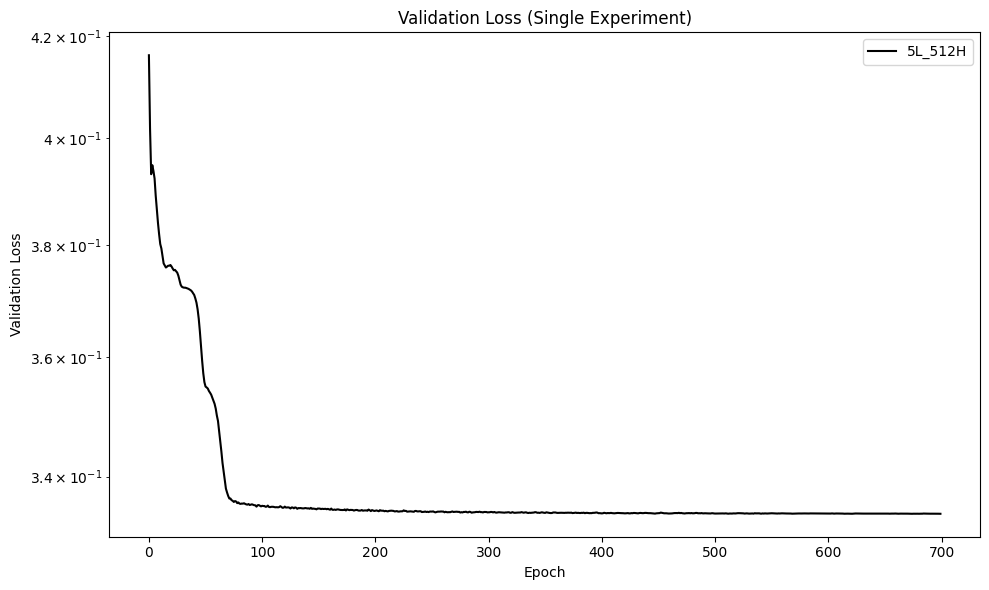

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

plt.figure(figsize=(10, 6))

for key in results:
    val_loss = results[key].get('val_loss', None)
    
    if val_loss is None:
        print(f"[경고] '{key}'에 'val_loss'가 없습니다.")
        continue

    # label에 layer/hidden_dim 정보 표시
    label = key

    plt.plot(val_loss, label=label, color="black")  # 단일 실험이므로 색상 고정

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.yscale("log")
plt.title("Validation Loss (Single Experiment)")
plt.legend()
plt.tight_layout()
plt.show()
